### LSTM NN 

In this notebook, we implement LSTM Neural Network for our classification task, seeing whether it is capable of outperforming our traditional ML models (Random Forest, XGBoost, etc.).
Our motivation for testing such type of model comes from its ability to capture long-term dependencies in time series data, which is a key feature of our dataset. Additionally, a large amount of papers read on the topic where aimig at assessing whether LSTM models would perform better than traditional ML models. These papers had opposing conclusions. In order to discernate, we will conduct the experiment ourselves. 

"""

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping

# Enable MPS acceleration for Apple Silicon
tf.config.set_visible_devices([], 'GPU')  # To ensure it uses the MPS backend
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Import the data and Prepare the data

In [4]:
import pandas as pd

# Load the training and test datasets
df_train_seq = pd.read_csv('df_train_seq.csv')
df_test_seq = pd.read_csv('df_test_seq.csv')

display(df_train_seq.head(), df_test_seq.head())

In [19]:
# Check for missing values in the entire dataset
missing_values = df_train_temp.isnull().sum()

# Display columns with missing values
missing_values = missing_values[missing_values > 0]

print("Columns with missing values and their counts:")
print(missing_values)

Columns with missing values and their counts:
Series([], dtype: int64)


In [20]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'df_train_temp' is your training dataset
# Sort the data by Patient_ID and Timestamp
df_train_temp = df_train_temp.sort_values(by=['patient_nbr', 'timestep']).reset_index(drop=True)

# Identify temporal and feature columns
temporal_columns = ['patient_nbr', 'timestep']  # Adjust if necessary
target_column = 'encoded_readmitted'  # Replace with the actual target column name
feature_columns = df_train_temp.columns.difference(temporal_columns + [target_column])

# Initialize lists for sequences
X = []  # Input sequences
Y = []  # Targets (readmission status)

# Group by Patient_ID and process each patient's data
grouped = df_train_temp.groupby('patient_nbr')

for _, group in grouped:
    features = group[feature_columns].values  # Extract feature values for the group
    targets = group[target_column].values     # Extract target values for the group
    num_timesteps = len(features)
    
    # Create sequences with varying lengths
    for i in range(num_timesteps - 1):  # Leave the last row for Y
        X.append(features[:i+1])  # Sequence up to the current timestep
        Y.append(targets[i+1])    # The target for the next timestep

# Pad sequences to the same length for LSTM input
max_sequence_length = max(len(seq) for seq in X)  # Determine the maximum sequence length
X_padded = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post')

# Convert Y to numpy array
Y = np.array(Y)

# Verify target values are as expected (0, 1, 2)
unique_targets = np.unique(Y)
if not set(unique_targets).issubset({0, 1, 2}):
    raise ValueError(f"Target column contains invalid values: {unique_targets}. Expected values: 0, 1, 2.")

# Display shapes
print("Shape of X (input sequences):", X_padded.shape)
print("Shape of Y (targets):", Y.shape)
print("Unique values in Y (targets):", unique_targets)

Shape of X (input sequences): (25657, 38, 68)
Shape of Y (targets): (25657,)
Unique values in Y (targets): [0 1 2]


In [21]:
# Example: Inspect sequences for a specific patient
patient_id = df_train_temp['patient_nbr'].iloc[0]  # Take the first patient
group = df_train_temp[df_train_temp['patient_nbr'] == patient_id]

# Check the sequences created for this patient
print(group[feature_columns])
print(group[target_column])

        PC1      PC10      PC11      PC12      PC13      PC14      PC15  \
0 -3.027153 -2.913113  0.251883  1.694339 -1.445468  0.485138 -0.165697   

       PC16      PC17      PC18  ...      PC62     PC63      PC64      PC65  \
0  0.043625  0.872321 -1.617301  ... -0.124102 -0.69377  0.199841 -0.222269   

      PC66      PC67       PC7       PC8       PC9  encounter_id  
0 -1.88178  0.222144  0.597786 -1.038842  0.253654      24437208  

[1 rows x 68 columns]
0    0
Name: encoded_readmitted, dtype: int64


In [22]:
from sklearn.model_selection import train_test_split

# X_test and T_test are in reality the validation set
X_train, X_validation, Y_train, Y_validation = train_test_split(X_padded, Y, test_size=0.15, random_state=42)

print(f"Training set shape: {X_train.shape}, {Y_train.shape}")
print(f"Testing set shape: {X_validation.shape}, {Y_validation.shape}")

Training set shape: (21808, 38, 68), (21808,)
Testing set shape: (3849, 38, 68), (3849,)


In [23]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels 0,1,2 (there was no need to label encode the strings values of the classes)
Y_train_encoded = to_categorical(Y_train, num_classes=3)
Y_test_encoded = to_categorical(Y_validation, num_classes=3)

print("Shape of Y_train_encoded:", Y_train_encoded.shape)
print("Shape of Y_test_encoded:", Y_test_encoded.shape)

Shape of Y_train_encoded: (21808, 3)
Shape of Y_test_encoded: (3849, 3)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))  # Dropout to reduce overfitting
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 classes (0, 1, 2)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                23800     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 26503 (103.53 KB)
Trainable params: 26503 (103.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [38]:
from tensorflow.keras.layers import Bidirectional

model2 = Sequential()
model2.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(50, return_sequences=False)))
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(3, activation='softmax'))
# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 38, 200)           135200    
 al)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 38, 200)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               100400    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 3)                

In [30]:
history = model.fit(X_train, Y_train_encoded, 
                    validation_data=(X_validation, Y_test_encoded), 
                    epochs=10, #try run it for 100, or 1000 epochs
                    batch_size=32, 
                    verbose=1)

Epoch 1/10
682/682 [==============================] - 4s 6ms/step - loss: 1.0134 - accuracy: 0.4595 - val_loss: 1.0250 - val_accuracy: 0.4513
Epoch 2/10
682/682 [==============================] - 4s 6ms/step - loss: 1.0133 - accuracy: 0.4604 - val_loss: 1.0240 - val_accuracy: 0.4515
Epoch 3/10
682/682 [==============================] - 4s 6ms/step - loss: 1.0130 - accuracy: 0.4596 - val_loss: 1.0245 - val_accuracy: 0.4513
Epoch 4/10
682/682 [==============================] - 4s 6ms/step - loss: 1.0128 - accuracy: 0.4585 - val_loss: 1.0283 - val_accuracy: 0.4297
Epoch 5/10
682/682 [==============================] - 4s 6ms/step - loss: 1.0134 - accuracy: 0.4584 - val_loss: 1.0249 - val_accuracy: 0.4515
Epoch 6/10
682/682 [==============================] - 4s 6ms/step - loss: 1.0129 - accuracy: 0.4593 - val_loss: 1.0260 - val_accuracy: 0.4505
Epoch 7/10
682/682 [==============================] - 4s 6ms/step - loss: 1.0130 - accuracy: 0.4600 - val_loss: 1.0238 - val_accuracy: 0.4510
Epoch 

In [40]:
history = model2.fit(X_train, Y_train_encoded, 
                    validation_data=(X_validation, Y_test_encoded), 
                    epochs=10, #try run it for 100, or 1000 epochs
                    batch_size=32, 
                    verbose=1)

Epoch 1/10
682/682 [==============================] - 24s 36ms/step - loss: 1.0145 - accuracy: 0.4559 - val_loss: 1.0242 - val_accuracy: 0.4523
Epoch 2/10
682/682 [==============================] - 22s 33ms/step - loss: 1.0141 - accuracy: 0.4568 - val_loss: 1.0251 - val_accuracy: 0.4518
Epoch 3/10
682/682 [==============================] - 24s 35ms/step - loss: 1.0144 - accuracy: 0.4576 - val_loss: 1.0231 - val_accuracy: 0.4515
Epoch 4/10
682/682 [==============================] - 25s 37ms/step - loss: 1.0143 - accuracy: 0.4588 - val_loss: 1.0226 - val_accuracy: 0.4521
Epoch 5/10
682/682 [==============================] - 23s 34ms/step - loss: 1.0137 - accuracy: 0.4562 - val_loss: 1.0238 - val_accuracy: 0.4513
Epoch 6/10
682/682 [==============================] - 21s 31ms/step - loss: 1.0141 - accuracy: 0.4584 - val_loss: 1.0231 - val_accuracy: 0.4518
Epoch 7/10
682/682 [==============================] - 21s 31ms/step - loss: 1.0136 - accuracy: 0.4586 - val_loss: 1.0219 - val_accuracy:

In [31]:
loss, accuracy = model.evaluate(X_validation, Y_test_encoded, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

121/121 [==============================] - 0s 2ms/step - loss: 1.0252 - accuracy: 0.4515
Validation Loss: 1.0251882076263428
Validation Accuracy: 0.4515458643436432


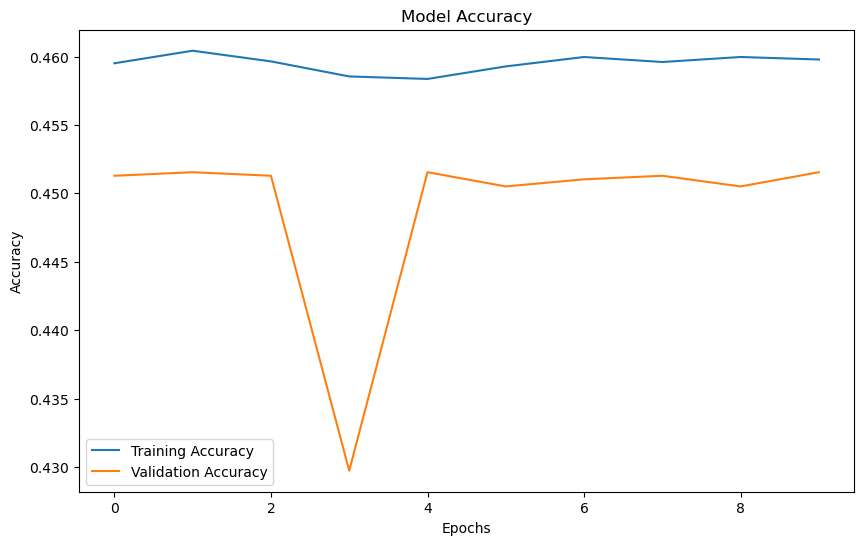

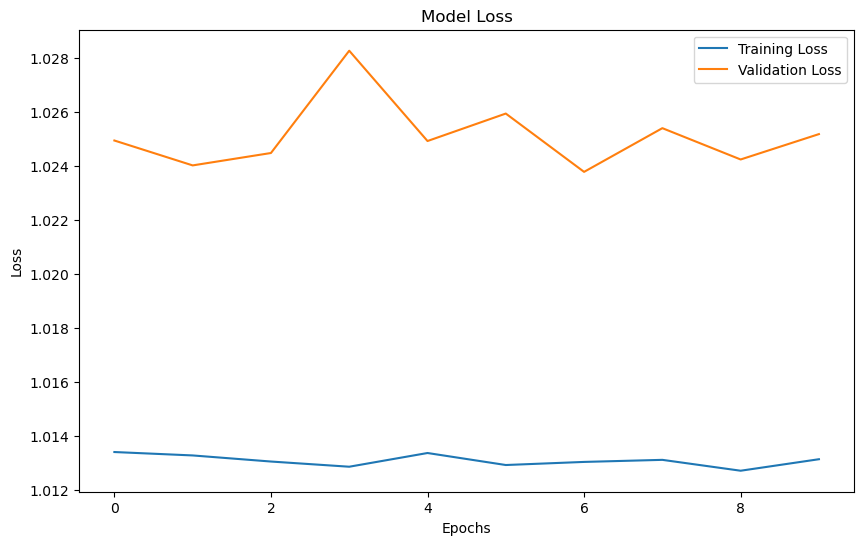

In [32]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert probabilities to class labels

print("Predicted Classes:", Y_pred_classes[:10])
print("True Classes:", Y_test[:10])

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(Y_test, Y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred_classes))

121/121 [==============================] - 0s 2ms/step
Predicted Classes: [2 1 2 2 2 2 1 1 1 1]
True Classes: [0 2 2 1 0 1 1 1 1 0]
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.00      0.01       691
           1       0.48      0.46      0.47      1695
           2       0.43      0.65      0.52      1463

    accuracy                           0.45      3849
   macro avg       0.40      0.37      0.33      3849
weighted avg       0.43      0.45      0.41      3849

Confusion Matrix:
[[  2 350 339]
 [  4 778 913]
 [  1 504 958]]


1. Baseline LSTM model


In [ ]:
# # Define LSTM model
# model = Sequential([
#     Masking(mask_value=-1, input_shape=(X.shape[1], X.shape[2])),  # Handle padded/missing values
#     LSTM(128, return_sequences=False),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(y.shape[1], activation='softmax')  # Output layer for multi-class classification
# ])

# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

Training

In [ ]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping]
)

Evaluation



In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

In [ ]:
# Save the model
model.save('lstm_readmission_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('lstm_readmission_model.h5')